<a href="https://colab.research.google.com/github/Mohamad-HuzaiFA/AI_Project/blob/main/FinalAIProject(BCSF21m018_BCSF21m010_BCSF21m044.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls /content/drive/MyDrive/HusnaSarwar/

building_metadata.csv  temp_merged.csv	train.csv	 weather_test.csv
sample_submission.csv  test.csv		Untitled0.ipynb  weather_train.csv


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# Import libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from plotly import tools, subplots
import plotly.offline as py

# Configure the libraries
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('display.max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle

In [ ]:

train = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/train.csv')

weather_train = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/weather_train.csv')
weather_test_df = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/weather_test.csv')
building_meta_df = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/building_metadata.csv')

test_df = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/HusnaSarwar/sample_submission.csv')

In [ ]:
# Function to get the first half of the dataset
def halve_dataset(df):
    half_length = len(df) // 2
    return df.iloc[:half_length]

# Halve each dataset and assign back to the same variable
train = halve_dataset(train)
weather_train = halve_dataset(weather_train)
weather_test_df = halve_dataset(weather_test_df)
building_meta_df = halve_dataset(building_meta_df)
test_df = halve_dataset(test_df)
sample_submission = halve_dataset(sample_submission)

# Now, each variable holds the halved dataset, but the original files in Google Drive are unaffected

In [ ]:
print('Size of train data', train.shape)
print('Size of weather_train data', weather_train.shape)
print('Size of weather_test_df data', weather_test_df.shape)
print('Size of building_meta_df data', building_meta_df.shape)

Size of train data (10108050, 4)
Size of weather_train data (69886, 9)
Size of weather_test_df data (138621, 9)
Size of building_meta_df data (724, 6)


In [ ]:
train_full = train.merge(building_meta_df, on='building_id', how='left')

In [ ]:
test_full = test_df.merge(building_meta_df, on='building_id', how='left')

In [ ]:
train_full = train_full.merge(weather_train, on=['site_id', 'timestamp'], how='left')

In [ ]:
test_full = test_full.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                # Choose appropriate reduced int type for integer columns
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Choose appropriate reduced float type for floating point columns
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# Reduce memory usage
train = reduce_mem_usage(train)
test_df = reduce_mem_usage(test_df)

train_full = reduce_mem_usage(train_full)
test_full = reduce_mem_usage(test_full)

weather_train = reduce_mem_usage(weather_train)
weather_test_df = reduce_mem_usage(weather_test_df)
building_meta_df = reduce_mem_usage(building_meta_df)

Mem. usage decreased to 144.60 Mb (53.1% reduction)
Mem. usage decreased to 298.24 Mb (53.1% reduction)
Mem. usage decreased to 453.07 Mb (63.3% reduction)
Mem. usage decreased to 934.50 Mb (63.3% reduction)
Mem. usage decreased to  1.53 Mb (68.1% reduction)
Mem. usage decreased to  3.04 Mb (68.1% reduction)
Mem. usage decreased to  0.01 Mb (60.2% reduction)


In [ ]:
# Converting from string to datetime columns
train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
train_full["timestamp"] = pd.to_datetime(train_full["timestamp"])
test_full["timestamp"] = pd.to_datetime(test_full["timestamp"])

**Taking a glimpse at the data**

In [ ]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
10108045,1174,2,2016-07-04 17:00:00,17.578100
10108046,1175,0,2016-07-04 17:00:00,38.001999
10108047,1176,0,2016-07-04 17:00:00,139.975006
10108048,1176,1,2016-07-04 17:00:00,278.888000


In [ ]:
train.timestamp.is_monotonic_increasing

True

In [ ]:
weather_train

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
69881,7,2016-12-24 22:00:00,2.800781,NaN,-0.399902,NaN,1018.0,270.0,3.099609
69882,7,2016-12-24 23:00:00,3.000000,NaN,-0.600098,NaN,1019.0,250.0,3.599609
69883,7,2016-12-25 00:00:00,3.099609,NaN,-0.799805,NaN,1020.0,240.0,4.101562
69884,7,2016-12-25 01:00:00,3.000000,NaN,-0.799805,NaN,1020.5,250.0,3.599609


In [ ]:
print('Weather data time span: ', weather_train.timestamp.min(), '—', weather_train.timestamp.max())
print('Unique sites: ', weather_train.site_id.unique())

Weather data time span:  2016-01-01 00:00:00 — 2016-12-31 23:00:00
Unique sites:  [0 1 2 3 4 5 6 7]


As expected, the weather training data covers the same period. There are 8 different sites of the weather stations that provided this data (so that each building is associated/located near one of the sites, which we can see below)

In [ ]:
building_meta_df

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
719,5,719,Education,28363,1919.0,2.0
720,5,720,Education,18202,1919.0,2.0
721,5,721,Education,121471,1966.0,3.0
722,5,722,Education,31635,1966.0,3.0


In [ ]:
test_df

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00
...,...,...,...,...
20848795,20848795,899,2,2017-06-11 13:00:00
20848796,20848796,900,0,2017-06-11 13:00:00
20848797,20848797,900,1,2017-06-11 13:00:00
20848798,20848798,900,2,2017-06-11 13:00:00


The training dataset consists of the same buildings, but from a different time period:

In [ ]:
test_df.timestamp.min(), test_df.timestamp.max()

('2017-01-01 00:00:00', '2018-12-31 23:00:00')

**Exploratory Data Analysis**

Let's look at the number of missing (NaN) values for each column:

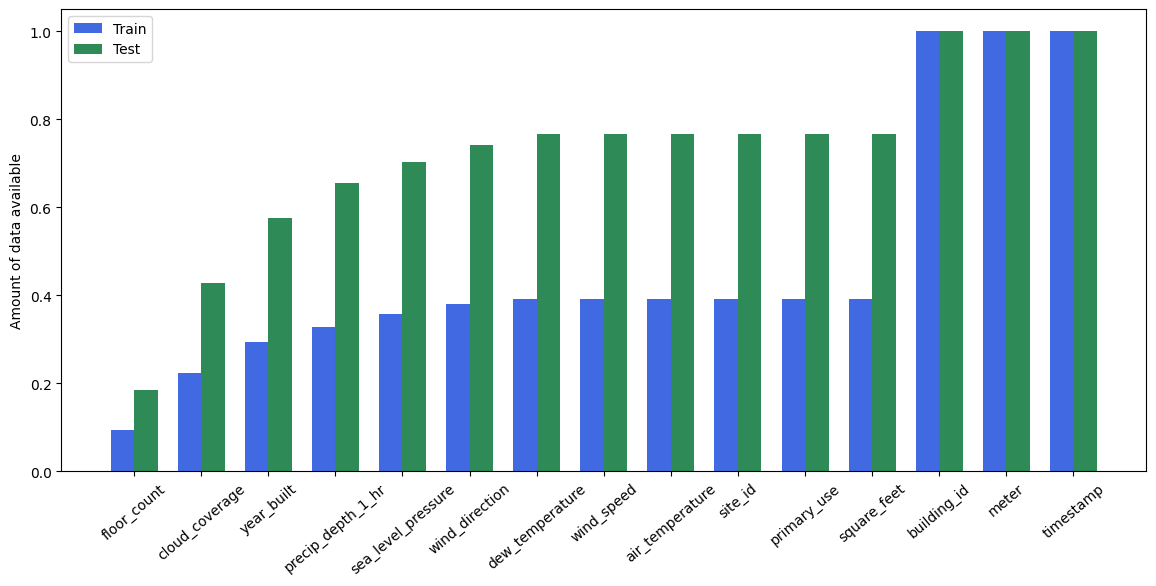

In [ ]:
# Count how many available values (in %) there are for each column, except the target column
train_data = (train_full.count() / len(train_full)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')

test_data = (test_full.count() / len(test_full)).drop('row_id').sort_values().values
tt = axes.bar(ind+width, test_data, width, color='seagreen')

axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train_full.count() / len(train_full)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr, tt], ['Train', 'Test']);

We can see that there are little data available on the floor counts and the years of the buildings.

Now let's include meter readings, plotting hour-of-observation vs. building_id, using different colors to indicate what kind of data was recorded at each hour (zero, non-zero, NaN):

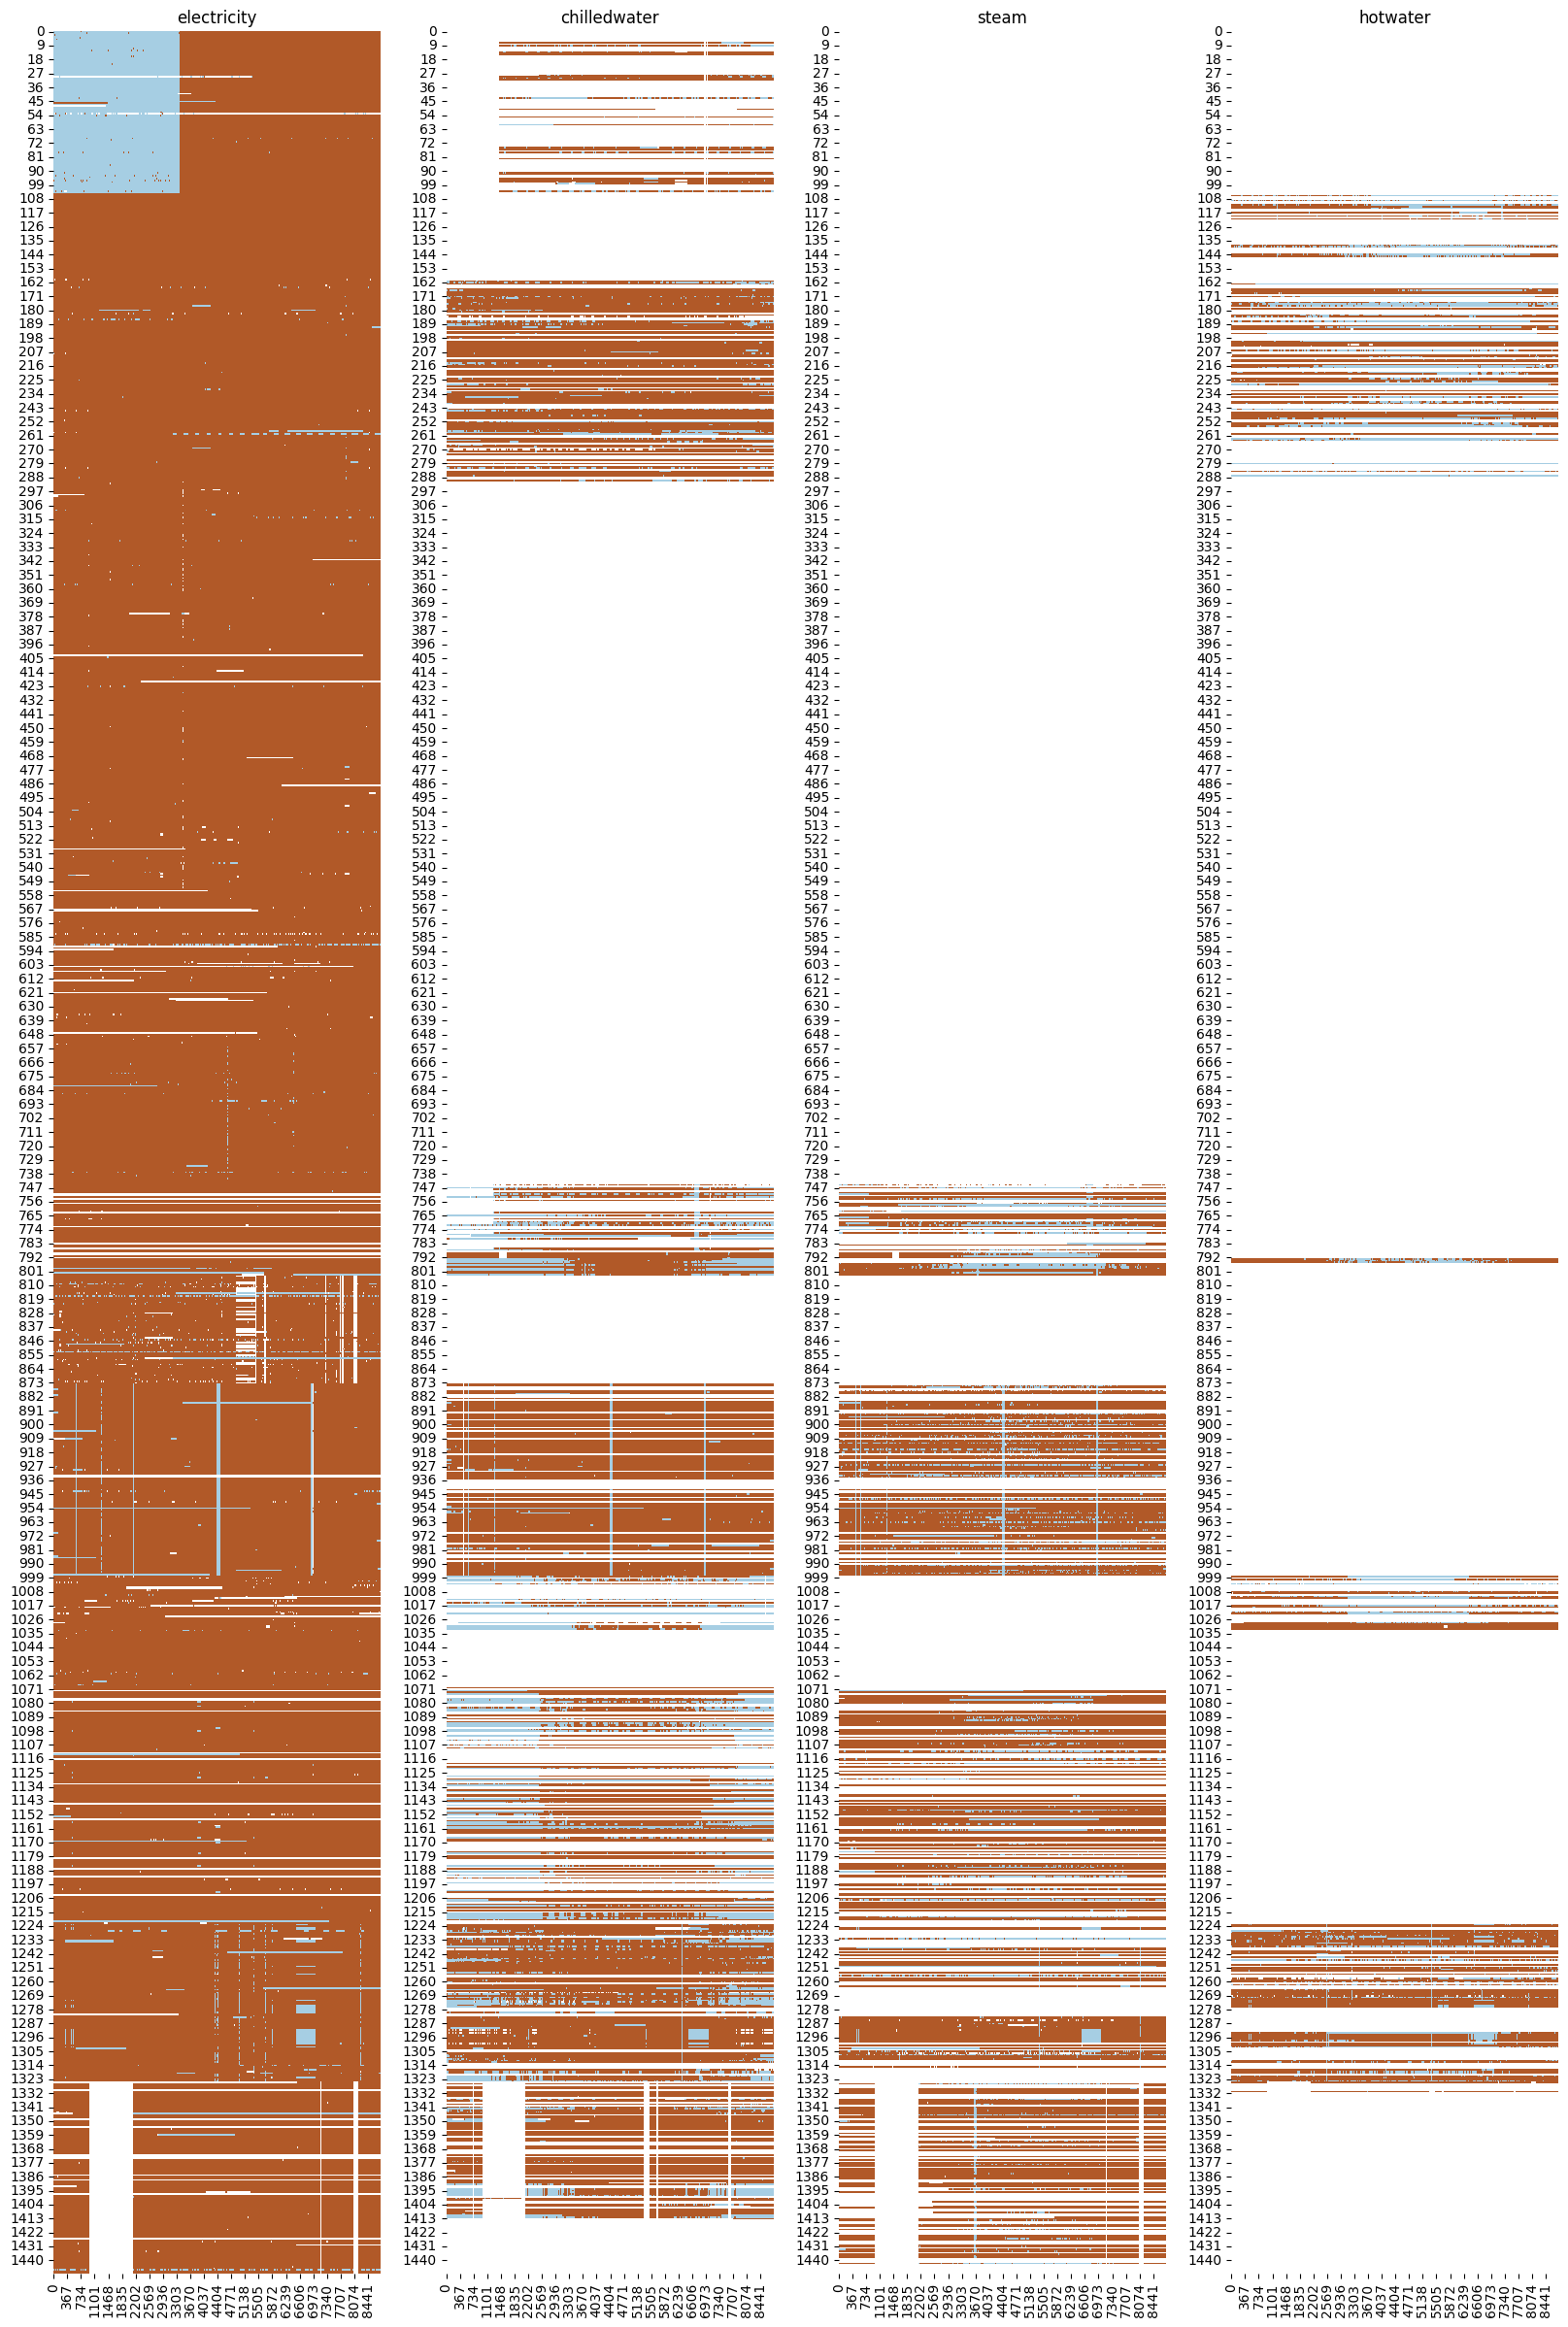

In [ ]:
train = train.set_index(['timestamp'])
buildings_count = len(train.building_id.unique())

meters_count = len(train.meter.unique())
meters = ['electricity', 'chilledwater', 'steam', 'hotwater']

PLOT_MISSING_VALUES = True

# Plot missing values per building/meter
if PLOT_MISSING_VALUES:
    f,a=plt.subplots(1,4,figsize=(20,30))

    for meter in np.arange(meters_count):
        # group by the consumed energy type (meter)
        df = train[train.meter==meter].copy().reset_index()

        # Convert from seconds to hours elapsed since the starting point of the dataset
        df['timestamp'] = df['timestamp'] - df['timestamp'].min()
        df['timestamp'] = df['timestamp'].dt.total_seconds() // 3600

        # Generate a matrix of missing and zero values
        missmap = np.empty((buildings_count, int(df.timestamp.max())+1))
        missmap.fill(np.nan)

        for l in df.values:
            if l[2]!=meter:
                continue
            # l[1] is a building id, l[0] is an hour, l[3] is a meter reading
            missmap[int(l[1]), int(l[0])] = 0 if l[3]==0 else 1

        a[meter].set_title(f'{meters[meter]}')
        sns.heatmap(missmap, cmap='Paired', ax=a[meter], cbar=False)

Legend:

X axis: hours elapsed since Jan 1st 2016, for each of the 4 meter types

Y axis: building_id

Brown: meter reading available with non-zero value

Light blue: meter reading available with zero value

White: missing meter reading

What we can conclude:



1.  Not every building has all meter types.
2.  There are a bunch of NaN values which often go in contiguous time intervals for multiple buidings (white rectangles in the graph above).

3.  Vertical blue lines indicate that for a number of buildings, the meter readings were zero at specific time intervals.







**Number of observations by day:**

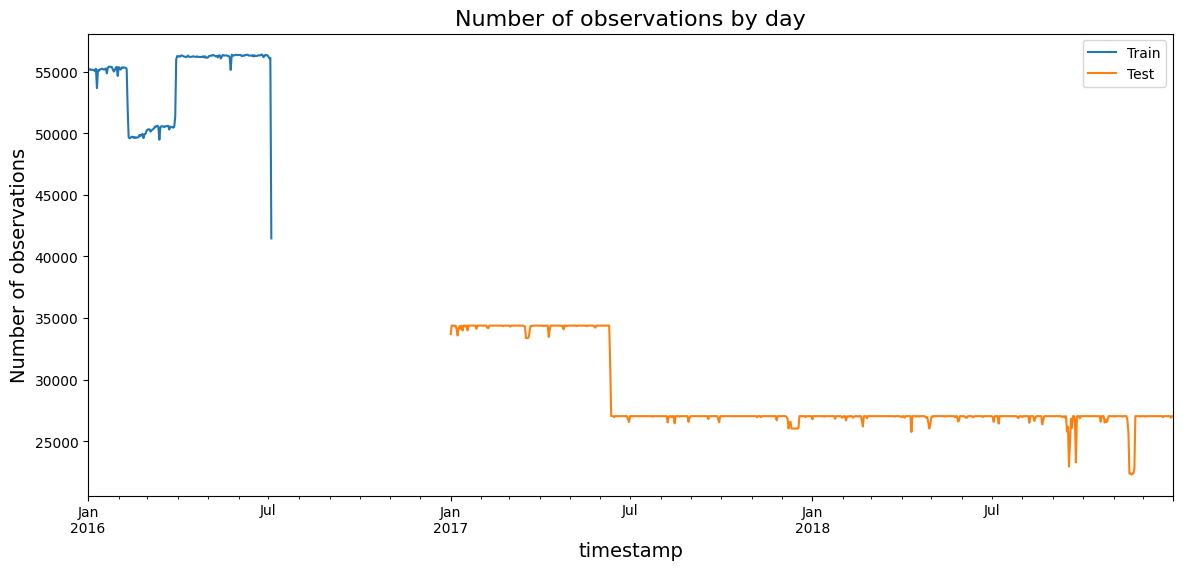

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
# Floor the dates to the nearest day, then count repetitions (i.e. dates of the same day)
train_full['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_xlabel('Date', fontsize=14);
test_full['timestamp'].dt.floor('d').value_counts().sort_index().plot(ax=axes).set_ylabel('Number of observations', fontsize=14);
axes.set_title('Number of observations by day', fontsize=16);
axes.legend(['Train', 'Test']);

This is something interesting. We can see that number of observations by day in testing dataset is always the same. But not in the training set.

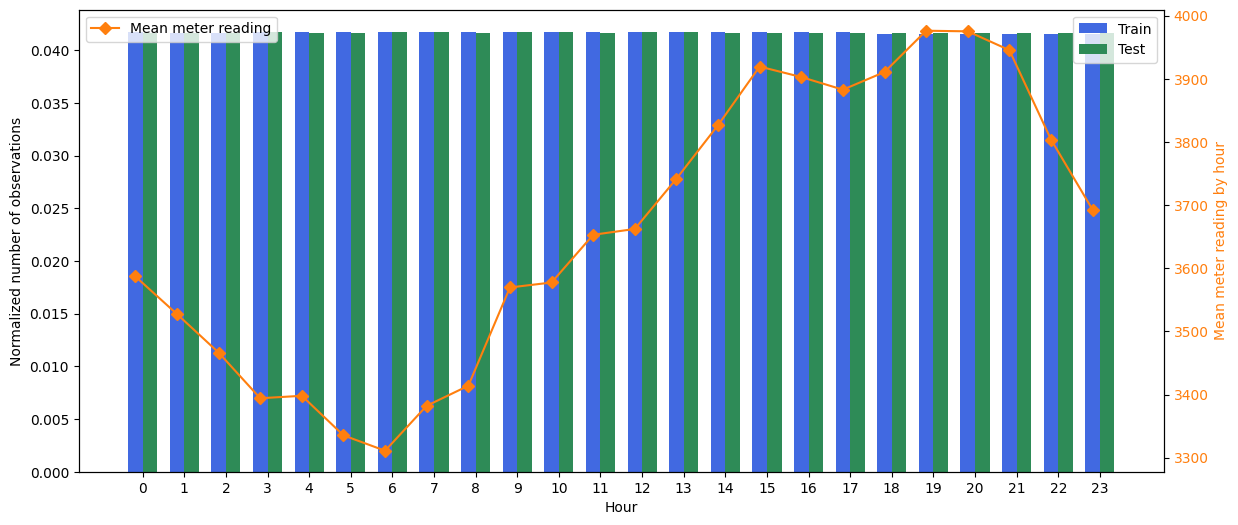

In [ ]:
train_data = train_full.copy()
test_data = test_full.copy()

train_data['hour'] = train_data['timestamp'].dt.hour
test_data['hour'] = test_data['timestamp'].dt.hour

# Calculate the number of values that have the same hour of the day in the dataset
plot_data = train_data['hour'].value_counts(dropna=False, normalize=True).sort_index().values
ind = np.arange(len(plot_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, plot_data, width, color='royalblue')

plot_data = test_data['hour'].value_counts(dropna=False, normalize=True).sort_index().values
tt = axes.bar(ind+width, plot_data, width, color='seagreen')

# Plot the number of observations of the same hour
axes.set_ylabel('Normalized number of observations');
axes.set_xlabel('Hour');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(train_data['hour'].value_counts().sort_index().index, rotation=0)
axes2 = axes.twinx()

# Plot the mean number of the meter reading in each hour
mr = axes2.plot(ind, train_data[['hour', 'meter_reading']].groupby('hour')['meter_reading'].mean().sort_index().values, 'D-', color='tab:orange', label='Mean meter reading');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean meter reading by hour', color='tab:orange');
axes.legend([tr, tt], ['Train', 'Test'], facecolor='white');
axes2.legend(loc=2, facecolor='white');

The train and test datasets appear to be pretty well balanced. Number of observations per hour is almost the same.

Also we can see that energy consumption raises up during the day and lowers during the night hours.

**Dealing with NaN values**

In [ ]:
train = train_full[train_full.meter == 0]
del train['meter']
train

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,0.000000,0.0,Education,7432.0,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,2016-01-01 00:00:00,0.000000,0.0,Education,2720.0,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,2016-01-01 00:00:00,0.000000,0.0,Education,5376.0,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,2016-01-01 00:00:00,0.000000,0.0,Education,23685.0,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,2016-01-01 00:00:00,0.000000,0.0,Education,116607.0,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10108041,1172,2016-07-04 17:00:00,199.451004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108043,1173,2016-07-04 17:00:00,25.322001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108044,1174,2016-07-04 17:00:00,28.795000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10108046,1175,2016-07-04 17:00:00,38.001999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the number of observations per day is not uniform as we saw earlier, we need to resample the dataset to a 1-hour frequency. However, some buildings have too little data to perform interpolation for resampling, so we'll need to discard them first.

In [ ]:
unique_buildings = train.building_id.unique()

# Extract time series data for each building from the dataset as a separate dataframe
buildings_slices = [train[train['building_id'] == id].set_index('timestamp')
                    for id in unique_buildings]
print('All buildings with electricity meter: ', len(buildings_slices))

All buildings with electricity meter:  1406


In [ ]:
# Define a desired time range with uniform frequency of 1 hour
desired_index = pd.date_range(start=train.timestamp.min(), \
                              end=train.timestamp.max(), freq='1H')

In [ ]:
buildings_slices_resampled = []
weather_train.set_index('timestamp', inplace=True)

for slice_df in buildings_slices:
    """For each building time series:
        1. Reindex based on the desired time range
        2. Perform resampling (this will introduce NaNs for missing time periods)
        3. Reindex back to the desired time range
    """
    slice_resampled = slice_df.reindex(slice_df.index.union(desired_index)) \
                              .asfreq('1h') \
                              .reindex(desired_index)

    # 4. Fill in the NaN values introduced by resampling
    new_rows_mask = slice_resampled.isna().all(axis=1) # newly inserted rows have all values NaN

    # Pick a sample non-empty row that was originally in the dataset
    original_sample_row = slice_df.iloc[0]

    # Fill in all the building_metadata for the new rows
    slice_resampled.loc[new_rows_mask, 'building_id': 'floor_count'] = \
        original_sample_row.loc['building_id': 'floor_count'].values

    # Fill in all the weather data for the new rows
    slice_resampled.update(weather_train[weather_train['site_id']==original_sample_row['site_id']])

    # Finish with assigning a NaN value to the meter_reading, in order to interpolate it later
    slice_resampled.loc[new_rows_mask, 'meter_reading'] = np.nan

    buildings_slices_resampled.append(slice_resampled)


In [ ]:
train_r = pd.concat(buildings_slices_resampled)
train_r

,building_id,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
2016-01-01 00:00:00,0.0,0.000000,0.0,Education,7432.0,2008.0,NaN,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
2016-01-01 01:00:00,0.0,0.000000,0.0,Education,7432.0,2008.0,NaN,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2016-01-01 02:00:00,0.0,0.000000,0.0,Education,7432.0,2008.0,NaN,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
2016-01-01 03:00:00,0.0,0.000000,0.0,Education,7432.0,2008.0,NaN,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
2016-01-01 04:00:00,0.0,0.000000,0.0,Education,7432.0,2008.0,NaN,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-04 13:00:00,555.0,25.480000,3.0,Education,22400.0,NaN,NaN,21.093750,NaN,18.90625,0.0,1019.0,160.0,5.101562
2016-07-04 14:00:00,555.0,25.040001,3.0,Education,22400.0,NaN,NaN,21.093750,NaN,18.90625,0.0,1019.5,150.0,3.599609
2016-07-04 15:00:00,555.0,25.490000,3.0,Education,22400.0,NaN,NaN,21.703125,8.0,18.90625,0.0,1019.0,150.0,4.101562
2016-07-04 16:00:00,555.0,25.350000,3.0,Education,22400.0,NaN,NaN,21.703125,NaN,18.90625,0.0,1019.0,170.0,4.101562


Now verify that the sampling rate is uniform:

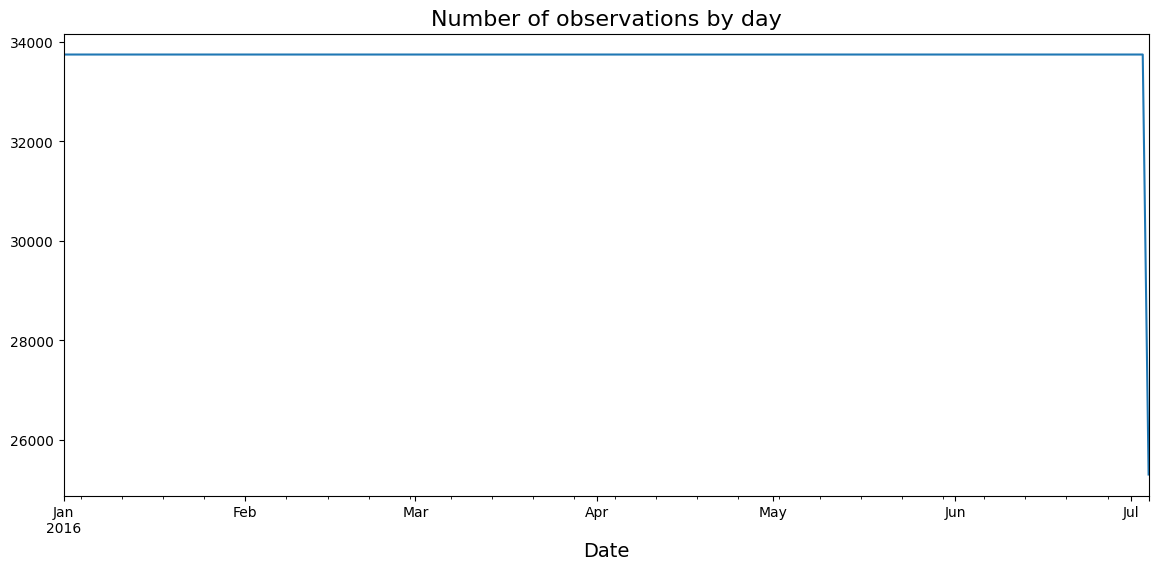

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6))

train_r.index.floor('d').value_counts().sort_index()\
.plot(ax=axes).set_xlabel('Date', fontsize=14)

axes.set_title('Number of observations by day', fontsize=16);


<Axes: ylabel='Frequency'>

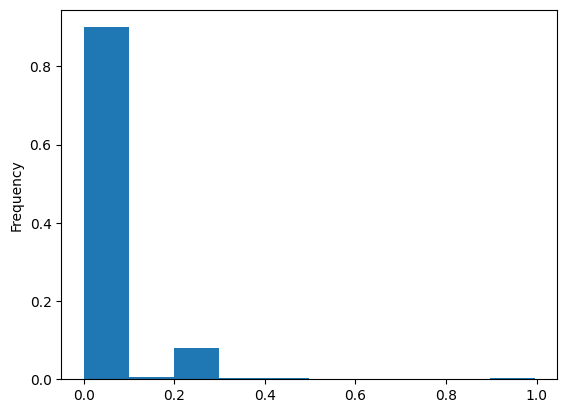

In [ ]:
# Plot a histogram of the missing values rate after resampling

n = len(desired_index)
building_nans = train_r.groupby('building_id')['meter_reading'].apply(lambda x: x.isna().sum() / n)
building_nans.plot(kind='hist', weights=np.ones_like(building_nans) / len(building_nans))

Discard all the buildings, who have more than NANS_THRESHOLD % of NaN values:

In [ ]:
NANS_THRESHOLD = 0

buildings_to_discard = (building_nans[building_nans > NANS_THRESHOLD]).index

# First resampled, now reduced
train_rr = train_r[~train_r['building_id'].isin(buildings_to_discard)]
train_rr.isna().sum()
# Plot the number of NaNs in each column

,0
building_id,0
meter_reading,0
site_id,548334
primary_use,548334
square_feet,548334
year_built,606288
floor_count,1003050
air_temperature,551183
cloud_coverage,1152301
dew_temperature,551185


In [ ]:
fill_metanans_strategy = 'DROP' # 'VIRTUAL', 'MEDIAN'
"""Fill in the stationary metabuilding NaN columns according to 3 strategies:
    1. MEDIAN: impute the NaN values with median values of the year_built and floor_count columns
    2. VIRTUAL: method based on the idea that the absence of the metabuilding info can actually reveal
    something about the building (e.g. that the building is old). In this case, we impute all the NaN
    values with 'virtual' stationary negative value, like -103 (the choice of a value doesn't matter here)
    3. DROP: drop the year_built and floor_count columns
"""

if fill_metanans_strategy=='VIRTUAL':
    train_rr['floor_count'] = train_rr['floor_count'].fillna(-103)
    train_rr['year_built'] = train_rr['year_built'].fillna(-103)
elif fill_metanans_strategy == 'MEDIAN':
    nans_mask = train_rr.isna()

    floor_nans = nans_mask['floor_count']
    year_nans = nans_mask['year_built']

    train_rr.loc[floor_nans, 'floor_count'] = train_rr['floor_count'].median(skipna=True)
    train_rr.loc[year_nans, 'year_built'] = train_rr['year_built'].median(skipna=True)
elif fill_metanans_strategy == 'DROP':
    train_rr = train_rr.drop(columns=['year_built', 'floor_count'])
else:
    print('Unsupported strategy.')

train_rr.isna().sum()

,0
building_id,0
meter_reading,0
site_id,548334
primary_use,548334
square_feet,548334
air_temperature,551183
cloud_coverage,1152301
dew_temperature,551185
precip_depth_1_hr,1074509
sea_level_pressure,859838


**Interpolating resampled time series**

Finally, let's use interpolation to fill in the remaining NaNs:

In [ ]:
interp_method = 'linear'

In [ ]:
unique_buildings = train_rr.building_id.unique()
features_to_fill = [ 'meter_reading',
                     'air_temperature',
                     'cloud_coverage',
                     'dew_temperature',
                     'precip_depth_1_hr',
                     'sea_level_pressure',
                     'wind_direction',
                     'wind_speed',  ]

building_slices = [train_rr[train_rr['building_id'] == id]
                    for id in unique_buildings]

train_rri = pd.concat([slice.interpolate(method=interp_method, axis='index', extrapolate=True)
                       for slice in building_slices])

# After interpolation, there are still some NaNs left outside the interpolation bounds.
# We'll fill them with the median values

nans_mask = train_rri.isna()
for f in features_to_fill:
    feature_nans = nans_mask[f]

    # Check if there are NaN values before filling
    if feature_nans.any():
        # Calculate and fill the median for the feature
        median_value = train_rri[f].median(skipna=True)
        train_rri.loc[feature_nans, f] = median_value

# Check if there are still NaN values
train_rri.isna().sum()

<ipython-input-41-1bfe80030f8b>:14: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-41-1bfe80030f8b>:14: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-41-1bfe80030f8b>:14: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-41-1bfe80030f8b>:14: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

<ipython-input-41-1bfe80030f8b>:14: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(cop

,0
building_id,0
meter_reading,0
site_id,548334
primary_use,548334
square_feet,548334
air_temperature,0
cloud_coverage,0
dew_temperature,0
precip_depth_1_hr,0
sea_level_pressure,0


In [ ]:
from numpy.random import choice, seed
seed(42)

""" Optionally drop a portion of the buildings left (to save computational time later)
    If BUILDINGS_DROP_VALUE is less than 1, it specifies a fraction of the buildings to drop (e.g. 0.5)
    If BUILDINGS_DROP_VALUE is bigger (or equal) than 1, it specifices the absolute value of the buildings to leave in the dataset (e.g. 1, 10, ...)"""

BUILDINGS_DROP_VALUE = 0.9

new_buildings = train_rri.building_id.unique()
new_buildings_count = len(new_buildings)

if BUILDINGS_DROP_VALUE < 1: # drop a fraction of the buildings left
    buildings_drop_count = int(np.ceil(new_buildings_count * BUILDINGS_DROP_VALUE))

    buildings_to_drop = choice(new_buildings, buildings_drop_count, replace = False)
else: # leave only BUILDINGS_DROP_VALUE buildings
    assert BUILDINGS_DROP_VALUE < new_buildings_count

    buildings_drop_count = new_buildings_count - BUILDINGS_DROP_VALUE
    buildings_to_drop = choice(new_buildings, buildings_drop_count, replace = False)

train_rri = train_rri[~train_rri['building_id'].isin(buildings_to_drop)]
print(f'{len(train_rri.building_id.unique())} buildings left in the dataset.')

34 buildings left in the dataset.


In [ ]:
train_rri

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
2016-01-01 00:00:00,20.0,0.000000,0.0,Education,110272.0,25.000000,6.0,20.000000,0.0,1019.5,0.0,0.000000
2016-01-01 01:00:00,20.0,91.988602,0.0,Education,110272.0,24.406250,4.0,21.093750,-1.0,1020.0,70.0,1.500000
2016-01-01 02:00:00,20.0,0.000000,0.0,Education,110272.0,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
2016-01-01 03:00:00,20.0,0.000000,0.0,Education,110272.0,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
2016-01-01 04:00:00,20.0,0.000000,0.0,Education,110272.0,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-04 13:00:00,1175.0,37.717999,NaN,NaN,NaN,14.000000,0.0,9.601562,0.0,1017.0,195.0,3.599609
2016-07-04 14:00:00,1175.0,38.066002,NaN,NaN,NaN,14.000000,0.0,9.601562,0.0,1017.0,195.0,3.599609
2016-07-04 15:00:00,1175.0,37.770000,NaN,NaN,NaN,14.000000,0.0,9.601562,0.0,1017.0,195.0,3.599609
2016-07-04 16:00:00,1175.0,38.050999,NaN,NaN,NaN,14.000000,0.0,9.601562,0.0,1017.0,195.0,3.599609


**Feature engineering & columns preprocessing**

Previously we saw that there is a clear pattern in temporal change of the mean electricity consumption during the day. So, let's extract this (and similar) information from the dataset and use it as new features.

In [ ]:
if fill_metanans_strategy != 'DROP':
    train_rri['age'] = train_rri['year_built'].max() - train_rri['year_built'] + 1
    train_rri['year_built'] = train_rri['year_built']-1900

train_rri['month_datetime'] = train_rri.index.month.astype(np.int8)
train_rri['hour_datetime'] = train_rri.index.hour.astype(np.int8)
train_rri['day_week'] = train_rri.index.dayofweek.astype(np.int8)
train_rri['day_month_datetime'] = train_rri.index.day.astype(np.int8)

train_rri['square_feet'] = np.log(train_rri['square_feet'])

In [ ]:
# Fill NaN values in integer columns with a placeholder value
train_rri.fillna({
    'building_id': -1,  # or any placeholder value
    'site_id': -1,
    'square_feet': 0,
    'year_built': 0,
    'floor_count': 0
}, inplace=True)

# Now, you can safely convert types
for feature in d_types:
    train_rri[feature] = train_rri[feature].astype(d_types[feature])


In [ ]:
# Convert to more lightweight types to save some memory
d_types = {'building_id': np.int16,
          'site_id': np.int8,
          'primary_use': 'category',
          'square_feet': np.int32,
          'air_temperature': np.float32,
          'cloud_coverage': np.float16,
          'dew_temperature': np.float32,
          'precip_depth_1_hr': np.float16,
          'sea_level_pressure': np.float32,
          'wind_direction': np.float16,
          'wind_speed': np.float32}
if fill_metanans_strategy != 'DROP':
    d_types['year_built'] = np.float16,
    d_types['floor_count'] = np.float16,

for feature in d_types:
    train_rri[feature] = train_rri[feature].astype(d_types[feature])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert our only categorical column to numeric
le = LabelEncoder()

train_rri['primary_use'] = le.fit_transform(train_rri['primary_use']).astype(np.int8)

In [ ]:
train_rri.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1013: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.10/dist-packages/pandas/co

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,hour_datetime,day_week,day_month_datetime
count,151572.000000,151572.000000,151572.000000,151572.000000,151572.000000,151572.000000,151572.0,151572.000000,151572.0,151572.000000,151572.0,151572.000000,151572.000000,151572.000000,151572.000000,151572.000000
mean,561.000000,82.043999,1.147059,2.588235,6.794118,14.225088,NaN,9.034385,0.0,1016.365662,NaN,3.996911,3.570659,11.487887,3.020188,15.407806
std,434.457483,166.768417,2.328000,2.001736,4.776055,6.783701,0.0,6.093085,NaN,5.379551,NaN,2.018558,1.761735,6.918698,2.007629,8.878409
min,20.000000,0.000000,-1.000000,0.000000,0.000000,-10.601562,0.0,-22.203125,-1.0,976.500000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
25%,105.000000,3.200000,-1.000000,0.000000,0.000000,10.000000,0.0,5.398438,0.0,1017.000000,140.0,3.099609,2.000000,5.000000,1.000000,8.000000
50%,675.500000,26.563000,0.000000,3.000000,10.000000,14.000000,0.0,9.601562,0.0,1017.000000,195.0,3.599609,4.000000,11.000000,3.000000,15.000000
75%,1062.000000,91.594252,3.000000,5.000000,10.000000,16.500000,2.0,11.101562,0.0,1017.000000,250.0,4.601562,5.000000,17.000000,5.000000,23.000000
max,1175.000000,3592.000000,5.000000,5.000000,12.000000,47.187500,9.0,25.000000,343.0,1039.000000,360.0,18.500000,7.000000,23.000000,6.000000,31.000000


**Feature engineering & columns**

Previously we saw that there is a clear pattern in temporal change of the mean electricity consumption during the day. So, let's extract this (and similar) information from the dataset and use it as new features.

In [ ]:
if fill_metanans_strategy != 'DROP':
    train_rri['age'] = train_rri['year_built'].max() - train_rri['year_built'] + 1
    train_rri['year_built'] = train_rri['year_built']-1900

train_rri['month_datetime'] = train_rri.index.month.astype(np.int8)
train_rri['hour_datetime'] = train_rri.index.hour.astype(np.int8)
train_rri['day_week'] = train_rri.index.dayofweek.astype(np.int8)
train_rri['day_month_datetime'] = train_rri.index.day.astype(np.int8)

train_rri['square_feet'] = np.log(train_rri['square_feet'])

In [ ]:


# Define the data types for columns
d_types = {
    'building_id': np.int16,
    'site_id': np.int8,
    'primary_use': 'category',
    'square_feet': np.int32,
    'air_temperature': np.float32,
    'cloud_coverage': np.float16,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float16,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float16,
    'wind_speed': np.float32
}

# Conditionally add columns to d_types if fill_metanans_strategy is not 'DROP'
if fill_metanans_strategy != 'DROP':
    d_types['year_built'] = np.float16
    d_types['floor_count'] = np.float16

# Handle missing columns
for feature in list(d_types.keys()):
    if feature not in train_rri.columns:
        print(f"Column '{feature}' not in DataFrame.")
        continue  # Skip if the column is missing

    # Convert data types
    train_rri[feature] = train_rri[feature].astype(d_types[feature])


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert our only categorical column to numeric
le = LabelEncoder()

train_rri['primary_use'] = le.fit_transform(train_rri['primary_use']).astype(np.int8)

In [ ]:
train_rri.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:731: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning:

overflow encountered in square

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1013: RuntimeWarning:

invalid value encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1479: RuntimeWarning:

overflow encountered in cast

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning:

overflow encountered in reduce

/usr/local/lib/python3.10/dist-packages/pandas/co

,building_id,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month_datetime,hour_datetime,day_week,day_month_datetime
count,151572.000000,151572.000000,151572.000000,151572.000000,151572.0,151572.000000,151572.0,151572.000000,151572.0,151572.000000,151572.0,151572.000000,151572.000000,151572.000000,151572.000000,151572.000000
mean,561.000000,82.043999,1.147059,2.588235,0.0,14.225088,NaN,9.034385,0.0,1016.365662,NaN,3.996911,3.570659,11.487887,3.020188,15.407806
std,434.457483,166.768417,2.328000,2.001736,0.0,6.783701,0.0,6.093085,NaN,5.379551,NaN,2.018558,1.761735,6.918698,2.007629,8.878409
min,20.000000,0.000000,-1.000000,0.000000,0.0,-10.601562,0.0,-22.203125,-1.0,976.500000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000
25%,105.000000,3.200000,-1.000000,0.000000,0.0,10.000000,0.0,5.398438,0.0,1017.000000,140.0,3.099609,2.000000,5.000000,1.000000,8.000000
50%,675.500000,26.563000,0.000000,3.000000,0.0,14.000000,0.0,9.601562,0.0,1017.000000,195.0,3.599609,4.000000,11.000000,3.000000,15.000000
75%,1062.000000,91.594252,3.000000,5.000000,0.0,16.500000,2.0,11.101562,0.0,1017.000000,250.0,4.601562,5.000000,17.000000,5.000000,23.000000
max,1175.000000,3592.000000,5.000000,5.000000,0.0,47.187500,9.0,25.000000,343.0,1039.000000,360.0,18.500000,7.000000,23.000000,6.000000,31.000000


**Splitting into Training & Testing datasets**

Unfortunately, the testing dataset provided by its authors will not work for us, because we don't know the target (y) values for it to be able to compute our own performance metrics.

**So, we'll choose the last months of spring, summer and autumn as our testing dataset (25%), leaving everything else for the training.**

In [ ]:
testing_months = [5, 8, 11]

test_df = train_rri[train_rri['month_datetime'].isin(testing_months)]
train_df = train_rri[~train_rri['month_datetime'].isin(testing_months)]

print('Training dataset length:', len(train_df))
print('Test dataset length:', len(test_df))

Training dataset length: 126276
Test dataset length: 25296


In [ ]:
# Save the datasets to be used later...
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')